In [1]:
import torchvision.models as models

In [28]:
resnet50 = models.resnet50(pretrained=True).cuda()

In [34]:
f = resnet50(torch.tensor(state[0].transpose([2,0,1])).view([1, 3, 480, 480]).type(torch.cuda.FloatTensor))

In [35]:
f.shape

torch.Size([1, 1000])

In [117]:
f.cpu().detach().numpy().shape

(1, 1000)

In [114]:
(1, *f.shape)

(1, 1, 1000)

In [104]:
y.shape

torch.Size([3, 480, 480])

In [105]:
q = np.random.random([480,480])

In [110]:
y[:, q>0.5] = 0

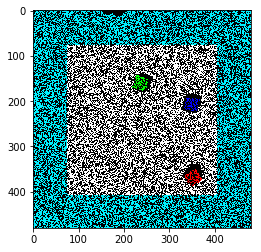

In [112]:
plt.imshow(y.cpu().permute([1,2,0]))

In [103]:
torch.cat([y, y]).shape

torch.Size([6, 480, 480])

In [70]:
y = copy.deepcopy(x[0])

In [71]:
y[y<0.9]=0

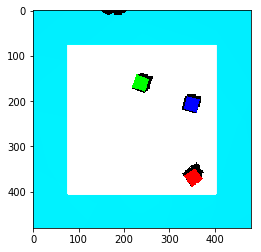

In [72]:
plt.imshow(y.cpu().permute([1,2,0]))

In [1]:
import sys
sys.path.append('../../ur5_mujoco')

from object_env import *

from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix

from sdf_module import *

In [2]:
sdf = SDFModule(rgb_feature=True, ucn_feature=True, resnet_feature=True)

/home/gun/Desktop/ur5_manipulation/object_wise/dqn/../../UnseenObjectClustering/fcn/config.py:439: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [3]:
env = UR5Env(render=False, camera_height=480, camera_width=480, control_freq=5, data_format='NHWC', xml_ver=0)
env = objectwise_env(env, num_blocks=3, mov_dist=0.08, detection=True)

Creating window glfw


In [4]:
state = env.reset()

In [5]:
state[0].shape

(480, 480, 3)

In [6]:
state[1].shape

(480, 480, 3)

In [7]:
st = time.time()
s0, s0_raw, f0 = sdf.get_sdf_features(state[0], rotate=True)
sg, sg_raw, fg = sdf.get_sdf_features(state[1], rotate=True)
et = time.time()
print(et-st)

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/torch/nn/functional.py:2589: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


1.812507152557373


In [9]:
np.concatenate(f0, 1).shape

(3, 1000)

In [28]:
np.concatenate(f0, 1).shape

(3, 1067)

In [29]:
np.concatenate(f0[0], 1).shape

AxisError: axis 1 is out of bounds for array of dimension 1

In [113]:
import pylab
NUM_COLORS = 5

cm = pylab.get_cmap('gist_rainbow')
for i in [0,2,4,1,3]:
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple
    print(color)
    #plt.imshow(np.ones([6,6,3])*color[:3])
    #plt.show()

# or if you really want a generator:
cgen = (cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS))

(1.0, 0.0, 0.16, 1.0)
(0.0, 1.0, 0.0, 1.0)
(0.16304347826086973, 0.0, 1.0, 1.0)
(1.0, 0.918918918918919, 0.0, 1.0)
(0.0, 0.9239130434782604, 1.0, 1.0)


In [7]:
st = time.time()
s0, s0_raw, (r0, f0) = sdf.get_sdf_features(state[0], rotate=True)
sg, sg_raw, (rg, fg) = sdf.get_sdf_features(state[1], rotate=True)
et = time.time()
print(et-st)

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/torch/nn/functional.py:2589: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


2.075721025466919


In [14]:
def norm(sdf):
    sdf_positive = sdf - sdf.min()
    return sdf_positive / sdf_positive.max()

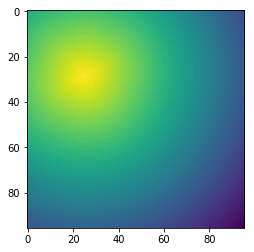

In [17]:
plt.imshow(norm(sg[0]))

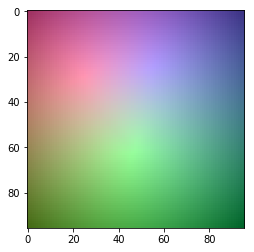

In [115]:
plt.imshow(norm(sg.transpose([1,2,0])))

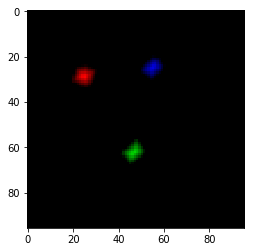

In [122]:
ss = sg.copy()
ss[sg<0] = 0
plt.imshow(norm(ss.transpose([1,2,0])))

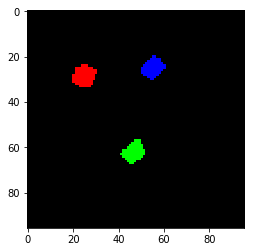

In [32]:
plt.imshow((sg.transpose([1,2,0])>0).astype(np.float))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


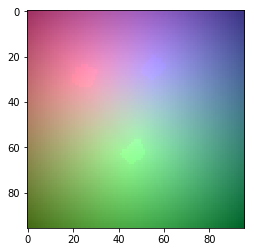

In [37]:
plt.imshow(norm(sg.transpose([1,2,0]))+(sg.transpose([1,2,0])>0).astype(np.float))

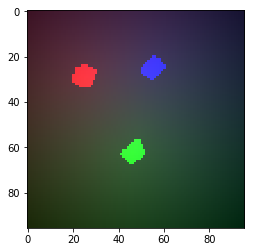

In [45]:
plt.imshow(norm(sg.transpose([1,2,0])+2*(sg.transpose([1,2,0])>0).astype(np.float)))

In [68]:
cm(0)[:3]

(1.0, 0.0, 0.16)

In [93]:
newsdf = norm(sg+2*(sg>0).astype(np.float))

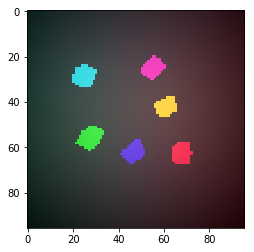

In [111]:
newsdf = norm(np.concatenate([s0, sg])+4*(np.concatenate([s0, sg])>0).astype(np.float))
empty = np.zeros([96,96,3])
for i in range(6):#len(newsdf)):
    empty += np.expand_dims(newsdf[i], 2) * np.array(cm(i/5)[:3])
plt.imshow(norm(empty))

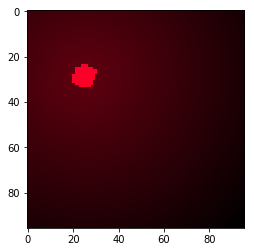

In [82]:
plt.imshow(np.expand_dims(newsdf[0], 2) * np.array(cm(0)[:3]))

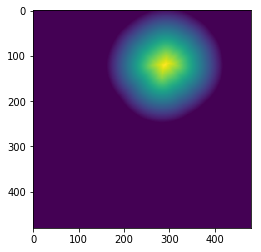

In [15]:
plt.imshow(np.clip(s0_raw[0], -100, 100))

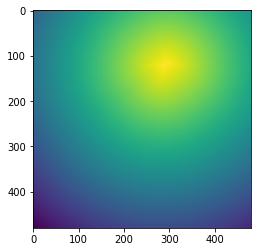

In [16]:
plt.imshow(s0_raw[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


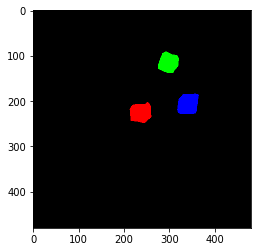

In [21]:
plt.imshow(s0_raw.transpose([1,2,0]))

In [8]:
linear_sum_assignment(distance_matrix(rg, r0)) 

(array([0, 1, 2]), array([1, 0, 2]))

In [9]:
linear_sum_assignment(distance_matrix(fg, f0)) 

(array([0, 1, 2]), array([1, 2, 0]))

In [10]:
st = time.time()
s0, s0_raw, (r0, f0) = sdf.get_sdf_features(state[0])
sg, sg_raw, (rg, fg) = sdf.get_sdf_features(state[1])
et = time.time()
print(et-st)

0.8314371109008789


In [11]:
linear_sum_assignment(distance_matrix(rg, r0)) 

(array([0, 1, 2]), array([1, 0, 2]))

In [12]:
linear_sum_assignment(distance_matrix(fg, f0)) 

(array([0, 1, 2]), array([2, 0, 1]))

In [13]:
mt, ft = sdf.get_masks(state[0], data_format='HWC', rotate=True)
mg, fg = sdf.get_masks(state[1], data_format='HWC', rotate=True)


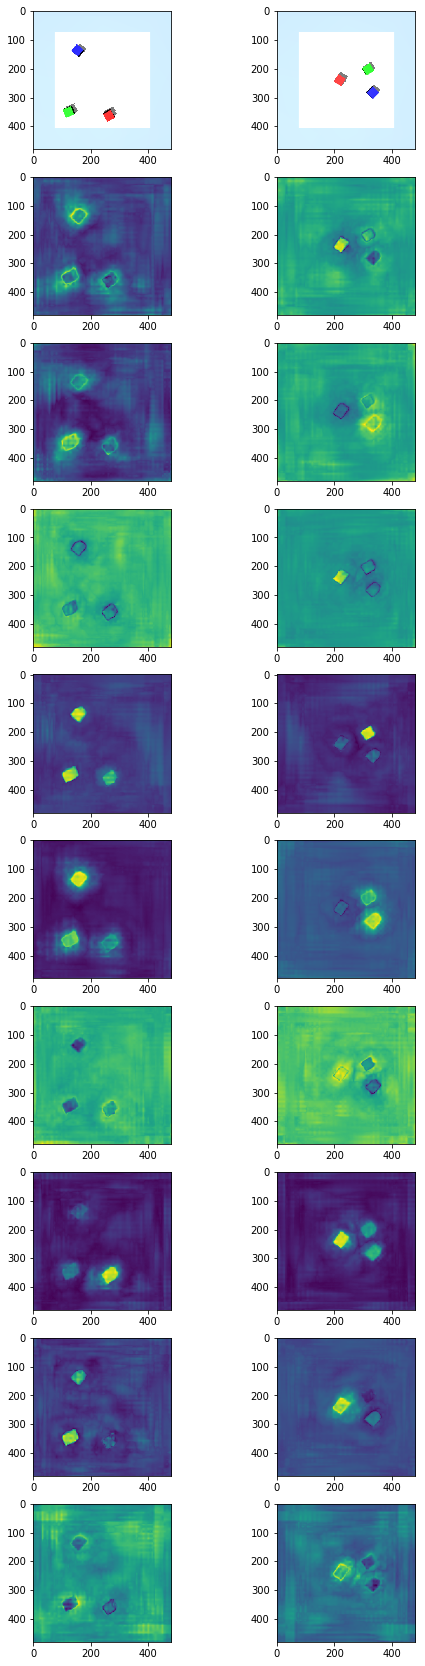

In [15]:
plt.figure(figsize=(8, 30))
N = 10
ax1 = plt.subplot(N, 2, 1)
ax2 = plt.subplot(N, 2, 2)
ax1.imshow(state[0])
ax2.imshow(state[1])
for i in range(1, N):
    _ax1 = plt.subplot(N, 2, 2*i+1)
    _ax2 = plt.subplot(N, 2, 2*i+2)
    _ax1.imshow(ft[i-1])
    _ax2.imshow(fg[i-1])

In [ ]:
sdf.object_matching((r0, f0), (rg, fg))

In [13]:
s_align = s0[sdf.object_matching((r0, f0), (rg, fg))]

In [22]:
np.round

<function numpy.round_(a, decimals=0, out=None)>

In [24]:
px, py = np.where(s_align[0]>0)
px = px.mean().round()
py = py.mean().round()
print(px, py)

55.0 36.0


In [35]:
gx, gy = np.where(sg[0]>0)
gx = gx.mean().round()
gy = gy.mean().round()
print(gx, gy)

59.0 51.0


In [25]:
from PIL import Image, ImageDraw

In [26]:
state[0].shape

(480, 480, 3)

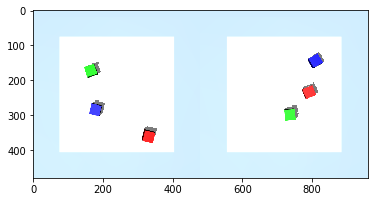

In [31]:
plt.imshow(np.concatenate([state[0], state[1]], 1))

In [51]:
im = Image.fromarray((np.concatenate([state[0], state[1]], 1)*255).astype(np.uint8))
draw = ImageDraw.Draw(im)
for i in range(3):
    px, py = np.where(s_align[i]>0)
    px = px.mean().round()
    py = py.mean().round()
    gx, gy = np.where(sg[i]>0)
    gx = gx.mean().round()
    gy = gy.mean().round()
    draw.line((5*py, 5*px, 5*gy+480, 5*gx), fill=128, width=3)
im.show()

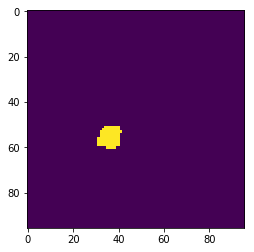

In [17]:
plt.imshow(s_align[0]>0)

In [10]:
st = time.time()
_ = sdf.get_masks(state[0])
_ = sdf.get_masks(state[1])
et = time.time()
print(et-st)

0.35448718070983887


In [14]:
st = time.time()
image = state[0]
# image = image.transpose([2, 0, 1])

im_tensor = torch.from_numpy(image).type(torch.float32).permute(2, 0, 1).unsqueeze(0).cuda()
features = sdf.network(im_tensor, None).detach()
out_label, selected_pixels = clustering_features(features, num_seeds=100)

et = time.time()
print(et-st)

0.17528820037841797


In [15]:
features.shape

torch.Size([1, 64, 480, 480])

In [16]:
torch.cat((features, features)).shape

torch.Size([2, 64, 480, 480])

In [18]:
out_labem, sp = clustering_features(torch.cat((features, features)), num_seeds=100)

In [20]:
out_labem.shape

torch.Size([2, 480, 480])

In [22]:
out_labem

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

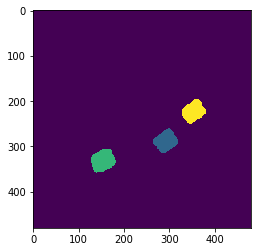

In [23]:
plt.imshow(out_labem[0])

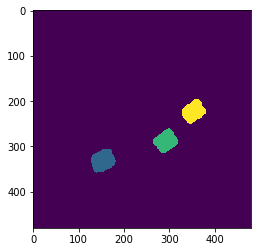

In [24]:
plt.imshow(out_labem[1])

In [9]:
im_tensor.shape

torch.Size([1, 3, 480, 480])

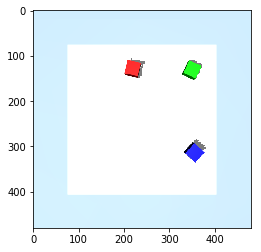

In [12]:
plt.imshow(state[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


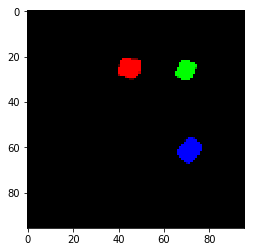

In [19]:
plt.imshow(s0.transpose([1,2,0]))

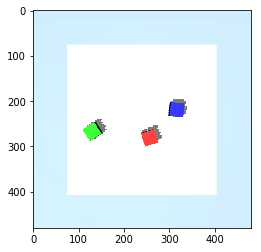

In [20]:
plt.imshow(state[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


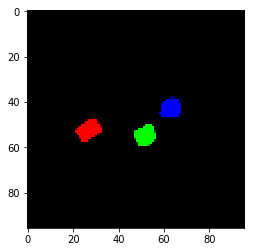

In [21]:
plt.imshow(sg[:3].transpose([1,2,0]))

In [22]:
np.array(f0).dot(np.array(fg).T)

array([[-0.02571546, -0.04282699, -0.01767311],
       [-0.04975494, -0.09087805,  0.8067699 ],
       [-0.02343216,  0.65797144,  0.01449735]], dtype=float32)

In [35]:
distance_matrix(f0, fg)

array([[1.3832215, 1.3970832, 1.378995 ],
       [1.4030297, 1.4335463, 0.5097574],
       [1.3814148, 0.741496 , 1.3553075]], dtype=float32)

In [36]:
xn = f0 / np.linalg.norm(f0, axis=1).reshape(3, 1)
yn = fg / np.linalg.norm(fg, axis=1).reshape(3, 1)

In [37]:
xn.dot(yn.T)

array([[-0.0276233 , -0.04589786, -0.01893939],
       [-0.05324371, -0.0970252 ,  0.86129785],
       [-0.02517637,  0.7053124 ,  0.01553965]], dtype=float32)

In [38]:
xn.dot(yn.T).argmax(1)

array([2, 2, 1])

In [39]:
distance_matrix(xn, yn)

array([[1.4336132, 1.4463042, 1.4275429],
       [1.4513744, 1.4812326, 0.5266917],
       [1.4319053, 0.7677077, 1.4031823]], dtype=float32)

In [41]:
row_ind, col_ind = linear_sum_assignment(distance_matrix(xn, yn))
col_ind

array([0, 2, 1])

In [43]:
r0n = r0 / np.linalg.norm(r0, axis=1).reshape(3, 1)
rgn = rg / np.linalg.norm(rg, axis=1).reshape(3, 1)

In [44]:
r0n.dot(rgn.T)

array([[0.87879245, 0.99949926, 0.86528088],
       [0.9862498 , 0.8148682 , 0.79804775],
       [0.89429903, 0.89581874, 0.99904485]])

In [45]:
r0n.dot(rgn.T).argmax(1)

array([1, 0, 2])

In [46]:
distance_matrix(r0, rg)

array([[0.53568231, 0.04464493, 0.56550031],
       [0.19326891, 0.65309234, 0.67140064],
       [0.51256376, 0.51316401, 0.06318709]])

In [47]:
distance_matrix(r0n, rgn)

array([[0.49235667, 0.03164611, 0.51907441],
       [0.16583244, 0.60849289, 0.63553481],
       [0.45978467, 0.45646743, 0.04370695]])

In [51]:
row_ind, col_ind = linear_sum_assignment(distance_matrix(r0, rg))
print(col_ind)

[1 0 2]


In [29]:
new0 = np.concatenate([r0, f0], axis=1)
newg = np.concatenate([rg, fg], axis=1)

In [30]:
new0n = new0 / np.linalg.norm(new0, axis=1).reshape(3, 1)
newgn = newg / np.linalg.norm(newg, axis=1).reshape(3, 1)

In [25]:
new0n.dot(newgn.T)

array([[0.65731094, 0.63809326, 0.5212285 ],
       [0.50072723, 0.51461945, 0.68156287],
       [0.56184808, 0.72777208, 0.4565355 ]])

In [26]:
new0n.dot(newgn.T).argmax(1)

array([0, 2, 1])

In [27]:
idx = new0n.dot(newgn.T).argmax(1)
new0n.dot(newgn[idx].T).argmax(1)

array([0, 1, 2])

In [28]:
ss, sg = sdf.get_aligned_sdfs(state[0], state[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


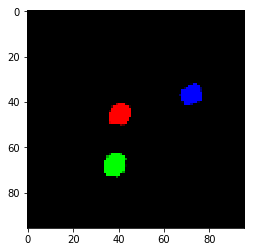

In [29]:
plt.imshow(ss.transpose([1,2,0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


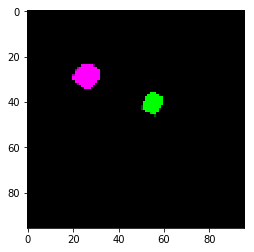

In [30]:
plt.imshow(sg.transpose([1,2,0]))

In [37]:
import cv2

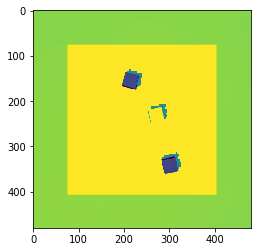

In [44]:
plt.imshow(state[0][:,:,0])

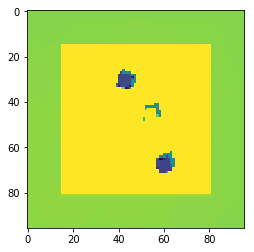

In [45]:
x = cv2.resize(state[0][:,:,0], (96, 96))
plt.imshow(x)

In [48]:
x.shape

(96, 96)

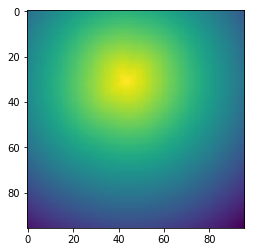

In [50]:
x = cv2.resize(s0[0], (96, 96))
plt.imshow(x)

In [46]:
s0.shape

(3, 480, 480)

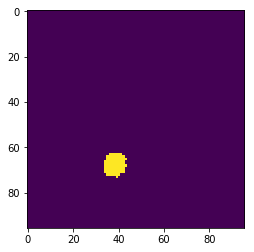

In [44]:
plt.imshow(s0[1]>0)

In [45]:
[px], [py] = np.where(s0[1]==s0[1].max())

In [46]:
px, py

(68, 38)

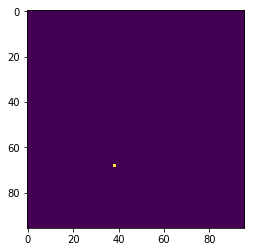

In [47]:
z = np.zeros([96, 96])
z[px, py] = 1
plt.imshow(z)

In [2]:
import numpy as np

In [35]:
x = np.random.random([4, 5])
y = np.random.random([3, 5])

In [36]:
x

array([[0.32760297, 0.0727951 , 0.18478654, 0.32826542, 0.42338854],
       [0.80688885, 0.31765814, 0.46727169, 0.88493521, 0.08802706],
       [0.35412284, 0.40088037, 0.57078666, 0.07389149, 0.65739878],
       [0.88349289, 0.80072712, 0.42438855, 0.89977359, 0.27898198]])

In [37]:
y

array([[0.06244564, 0.29301556, 0.06735517, 0.69928376, 0.60767946],
       [0.59664235, 0.22515784, 0.49826215, 0.71546733, 0.57226945],
       [0.12389847, 0.39324521, 0.64589465, 0.07616206, 0.93208619]])

In [38]:
x.dot(y.T)

array([[0.541069  , 0.78107985, 0.60820445],
       [0.84725169, 1.46928851, 0.67614541],
       [0.62918191, 1.01502362, 1.18856766],
       [1.11710923, 1.72228749, 1.02701967]])

In [39]:
x.dot(y.T).argmax(1)

array([1, 1, 2, 1])

In [40]:
x.dot(y.T).argmax(0)

array([3, 3, 2])

In [41]:
x[x.dot(y.T).argmax(0)]

array([[0.88349289, 0.80072712, 0.42438855, 0.89977359, 0.27898198],
       [0.88349289, 0.80072712, 0.42438855, 0.89977359, 0.27898198],
       [0.35412284, 0.40088037, 0.57078666, 0.07389149, 0.65739878]])

In [63]:
xn = x / np.linalg.norm(x, axis=1).reshape(4, 1)
yn = y / np.linalg.norm(y, axis=1).reshape(3, 1)

In [64]:
xn.dot(yn.T)

array([[0.68603269, 0.89357979, 0.79795091],
       [0.66681712, 0.76665397, 0.7141124 ],
       [0.67188906, 0.72310934, 0.73731868],
       [0.68371166, 0.83301717, 0.91036777]])

In [65]:
xn.dot(yn.T).argmax(1)

array([1, 1, 2, 2])